<a href="https://colab.research.google.com/github/SeyyedAhmadRokni/Karshenasi-Project/blob/main/KProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import warnings
import re
import time
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Install required packages
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import xgboost as xgb
except ImportError:
    print("Installing XGBoost...")
    install_package("xgboost")
    import xgboost as xgb

try:
    import lightgbm as lgb
except ImportError:
    print("Installing LightGBM...")
    install_package("lightgbm")
    import lightgbm as lgb

warnings.filterwarnings('ignore')

# ResNet Block برای tabular data
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.3):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(out_features, out_features),
            nn.BatchNorm1d(out_features)
        )

        # Skip connection
        self.skip = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.skip(x)
        out = self.block(x)
        out = out + identity
        return self.activation(out)


# ResNet برای Tabular Data
class TabularResNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[512, 256, 128, 64]):
        super(TabularResNet, self).__init__()

        # Input layer
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

        # Residual blocks
        self.residual_blocks = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.residual_blocks.append(
                ResidualBlock(hidden_dims[i], hidden_dims[i+1], dropout=0.3)
            )

        # Output layer
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(hidden_dims[-1], num_classes)
        )

        # Weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm1d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)

    def forward(self, x):
        x = x.squeeze(1) if x.dim() == 3 else x
        x = self.input_layer(x)

        for block in self.residual_blocks:
            x = block(x)

        return self.classifier(x)


class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(pd.factorize(y)[0], dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def log(msg):
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] {msg}")


def train_neural_model(model, train_loader, test_loader, device, model_name, class_weights=None):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=0.01, epochs=200, steps_per_epoch=len(train_loader),
        pct_start=0.1, anneal_strategy='cos'
    )

    best_acc = 0
    patience = 50
    no_improve = 0

    log(f"Start training {model_name}...")

    for epoch in range(200):
        # Train
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()

        # Test
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                _, predicted = torch.max(outputs, 1)
                total += y_batch.size(0)
                correct += (predicted.cpu() == y_batch).sum().item()

        train_acc = correct_train / total_train
        test_acc = correct / total

        if (epoch + 1) % 10 == 0:
            log(f"{model_name} Epoch {epoch+1} - Train Loss: {train_loss/len(train_loader):.4f}, "
                f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

        # Early stopping
        if test_acc > best_acc:
            best_acc = test_acc
            no_improve = 0
            torch.save(model.state_dict(), f'/content/{model_name.lower()}_best.pth')
        else:
            no_improve += 1
            if no_improve >= patience and epoch > 60:
                log(f"Early stopping at epoch {epoch+1}, Best acc: {best_acc:.4f}")
                break

    model.load_state_dict(torch.load(f'/content/{model_name.lower()}_best.pth'))
    return model


def train_xgboost(X_train, y_train, X_test, y_test):
    log("Training XGBoost...")

    # Convert labels to numeric
    label_encoder = {label: idx for idx, label in enumerate(y_train.unique())}
    y_train_encoded = y_train.map(label_encoder)
    y_test_encoded = y_test.map(label_encoder)

    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
    sample_weights = np.array([class_weights[i] for i in y_train_encoded])

    # XGBoost with best hyperparameters for tabular data
    xgb_model = xgb.XGBClassifier(
        n_estimators=2000,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='mlogloss',
        early_stopping_rounds=100,
        n_jobs=-1
    )

    # Fit with early stopping
    xgb_model.fit(
        X_train, y_train_encoded,
        sample_weight=sample_weights,
        eval_set=[(X_test, y_test_encoded)],
        verbose=50
    )

    # Predict
    y_pred_encoded = xgb_model.predict(X_test)
    reverse_encoder = {idx: label for label, idx in label_encoder.items()}
    y_pred = [reverse_encoder[pred] for pred in y_pred_encoded]

    return y_pred, xgb_model


def train_lightgbm(X_train, y_train, X_test, y_test):
    log("Training LightGBM...")

    # Convert labels to numeric
    label_encoder = {label: idx for idx, label in enumerate(y_train.unique())}
    y_train_encoded = y_train.map(label_encoder)
    y_test_encoded = y_test.map(label_encoder)

    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
    sample_weights = np.array([class_weights[i] for i in y_train_encoded])

    # LightGBM with best hyperparameters
    lgb_model = lgb.LGBMClassifier(
        n_estimators=2000,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    # Fit with early stopping
    lgb_model.fit(
        X_train, y_train_encoded,
        sample_weight=sample_weights,
        eval_set=[(X_test, y_test_encoded)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(50)]
    )

    # Predict
    y_pred_encoded = lgb_model.predict(X_test)
    reverse_encoder = {idx: label for label, idx in label_encoder.items()}
    y_pred = [reverse_encoder[pred] for pred in y_pred_encoded]

    return y_pred, lgb_model


def evaluate_models(results):
    print("="*60)
    print("FINAL RESULTS COMPARISON")
    print("="*60)

    for name, data in results.items():
        print(f"\n{name}:")
        print("-" * 40)
        print(f"Precision: {precision_score(data['y_test'], data['y_pred'], average='weighted'):.4f}")
        print(f"Recall: {recall_score(data['y_test'], data['y_pred'], average='weighted'):.4f}")
        print(f"F1-Score: {f1_score(data['y_test'], data['y_pred'], average='weighted'):.4f}")
        print(f"Accuracy: {accuracy_score(data['y_test'], data['y_pred']):.4f}")

        # Per-class metrics
        report = classification_report(data['y_test'], data['y_pred'], output_dict=True)
        print("\nPer-class F1-scores:")
        for class_name in sorted(report.keys()):
            if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
                print(f"  Class {class_name}: {report[class_name]['f1-score']:.4f}")


def extract_features(text):
    pattern = r"Student (\d+) in course (\d+) clicked (\d+) times on (\w+)\."
    match = re.match(pattern, text)
    if match:
        student_id = int(match.group(1))
        course = int(match.group(2))
        clicks = int(match.group(3))
        activity = match.group(4)

        return {
            "id_student": student_id,
            "course": course,
            "sum_click": clicks,
            "activity_type": activity,
            # ویژگی‌های اضافی
            "click_intensity": min(clicks / 10.0, 5.0),
            "is_high_activity": 1 if clicks > 50 else 0,
            "course_student_interaction": course * (student_id % 100),
            "log_clicks": np.log1p(clicks),  # log transform
        }
    return None


In [8]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# تنظیمات
BATCH_SIZE = 1024
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. بارگذاری داده از Google Drive
log("Loading data from Google Drive...")
df_train = pd.read_csv("/content/drive/MyDrive/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test.csv")

# 2. استخراج ویژگی
log("Extracting features...")
train_features = df_train["text_description"].apply(extract_features).apply(pd.Series)
test_features = df_test["text_description"].apply(extract_features).apply(pd.Series)

# 3. پردازش activity_type
all_activity_types = pd.concat([train_features["activity_type"], test_features["activity_type"]])
cat_mapping = {cat: idx for idx, cat in enumerate(all_activity_types.unique()) if cat is not None}
train_features["activity_type"] = train_features["activity_type"].map(cat_mapping)
test_features["activity_type"] = test_features["activity_type"].map(cat_mapping)

# 4. آماده‌سازی نهایی
train_features["final_result"] = df_train["final_result"]
test_features["final_result"] = df_test["final_result"]

train_features = train_features.dropna()
test_features = test_features.dropna()

X_train = train_features.drop(columns=["final_result"])
y_train = train_features["final_result"]
X_test = test_features.drop(columns=["final_result"])
y_test = test_features["final_result"]

log(f"Final shapes - Train: {X_train.shape}, Test: {X_test.shape}")
log(f"Classes: {len(y_train.unique())}, Device: {device}")

# 5. نرمال‌سازی برای neural networks
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# تنظیمات برای neural networks
num_classes = len(y_train.unique())
input_dim = X_train.shape[1]

# وزن کلاس‌ها
classes = np.unique(y_train)
class_counts = np.bincount(pd.factorize(y_train)[0])
total_samples = len(y_train)
class_weights = total_samples / (len(classes) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# DataLoaders for neural networks
train_dataset = CustomDataset(X_train_scaled, y_train)
test_dataset = CustomDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

results = {}

# 1. XGBoost (معمولاً بهترین برای tabular data)
y_pred_xgb = train_xgboost(X_train, y_train, X_test, y_test)
results["XGBoost"] = {"y_test": y_test, "y_pred": y_pred_xgb}

# 2. LightGBM
y_pred_lgb = train_lightgbm(X_train, y_train, X_test, y_test)
results["LightGBM"] = {"y_test": y_test, "y_pred": y_pred_lgb}

# 3. TabularResNet
log("Training TabularResNet...")
resnet = TabularResNet(input_dim, num_classes).to(device)
resnet = train_neural_model(resnet, train_loader, test_loader, device, "TabularResNet", class_weights)

# پیش‌بینی ResNet
resnet.eval()
y_pred_resnet = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = resnet(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred_resnet.extend(predicted.cpu().numpy())

label_mapping = {i: label for i, label in enumerate(y_train.unique())}
y_pred_resnet = [label_mapping[pred] for pred in y_pred_resnet]
results["TabularResNet"] = {"y_test": y_test, "y_pred": y_pred_resnet}

# 4. Random Forest (کلاسیک ولی قدرتمند)
log("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
results["Random Forest"] = {"y_test": y_test, "y_pred": y_pred_rf}

# ارزیابی نهایی
log("Final evaluation...")
evaluate_models(results)

# نمایش بهترین مدل
best_model = max(results.items(), key=lambda x: accuracy_score(x[1]['y_test'], x[1]['y_pred']))
print(f"\n🏆 BEST MODEL: {best_model[0]} with accuracy: {accuracy_score(best_model[1]['y_test'], best_model[1]['y_pred']):.4f}")

Mounted at /content/drive
[2025-09-20 13:36:28] Loading data from Google Drive...
[2025-09-20 13:36:32] Extracting features...
[2025-09-20 13:37:08] Final shapes - Train: (170484, 8), Test: (42622, 8)
[2025-09-20 13:37:08] Classes: 4, Device: cuda
[2025-09-20 13:37:08] Training XGBoost...
[0]	validation_0-mlogloss:1.38315
[50]	validation_0-mlogloss:1.27834
[100]	validation_0-mlogloss:1.22626
[150]	validation_0-mlogloss:1.18735
[200]	validation_0-mlogloss:1.15090
[250]	validation_0-mlogloss:1.12036
[300]	validation_0-mlogloss:1.09027
[350]	validation_0-mlogloss:1.06408
[400]	validation_0-mlogloss:1.03920
[450]	validation_0-mlogloss:1.01900
[500]	validation_0-mlogloss:0.99611
[550]	validation_0-mlogloss:0.97714
[600]	validation_0-mlogloss:0.95708
[650]	validation_0-mlogloss:0.93642
[700]	validation_0-mlogloss:0.91846
[750]	validation_0-mlogloss:0.89990
[800]	validation_0-mlogloss:0.88365
[850]	validation_0-mlogloss:0.86839
[900]	validation_0-mlogloss:0.85258
[950]	validation_0-mlogloss:0

[2025-09-20 13:42:19] TabularResNet Epoch 10 - Train Loss: 1.3864, Train Acc: 0.2540, Test Acc: 0.1938


[2025-09-20 13:42:44] TabularResNet Epoch 20 - Train Loss: 1.3864, Train Acc: 0.2823, Test Acc: 0.1232


[2025-09-20 13:43:09] TabularResNet Epoch 30 - Train Loss: 1.3865, Train Acc: 0.2659, Test Acc: 0.1232


[2025-09-20 13:43:35] TabularResNet Epoch 40 - Train Loss: 1.3865, Train Acc: 0.2181, Test Acc: 0.1938


[2025-09-20 13:44:00] TabularResNet Epoch 50 - Train Loss: 1.3864, Train Acc: 0.2255, Test Acc: 0.1232


[2025-09-20 13:44:25] TabularResNet Epoch 60 - Train Loss: 1.3864, Train Acc: 0.2884, Test Acc: 0.5914


[2025-09-20 13:44:31] Early stopping at epoch 62, Best acc: 0.5915
[2025-09-20 13:44:31] Training Random Forest...
[2025-09-20 13:46:47] Final evaluation...
FINAL RESULTS COMPARISON

XGBoost:
----------------------------------------
Precision: 0.8290
Recall: 0.8044
F1-Score: 0.8103
Accuracy: 0.8044

Per-class F1-scores:
  Class 0: 0.8428
  Class 1: 0.6959
  Class 2: 0.8519
  Class 3: 0.6262

LightGBM:
----------------------------------------
Precision: 0.7535
Recall: 0.6818
F1-Score: 0.6948
Accuracy: 0.6818

Per-class F1-scores:
  Class 0: 0.7271
  Class 1: 0.5773
  Class 2: 0.7384
  Class 3: 0.5026

TabularResNet:
----------------------------------------
Precision: 0.4537
Recall: 0.5915
F1-Score: 0.4403
Accuracy: 0.5915

Per-class F1-scores:
  Class 0: 0.0036
  Class 1: 0.0000
  Class 2: 0.7432
  Class 3: 0.0000

Random Forest:
----------------------------------------
Precision: 0.5837
Recall: 0.4877
F1-Score: 0.5109
Accuracy: 0.4877

Per-class F1-scores:
  Class 0: 0.4796
  Class 1: 

In [3]:
!pip install torchviz

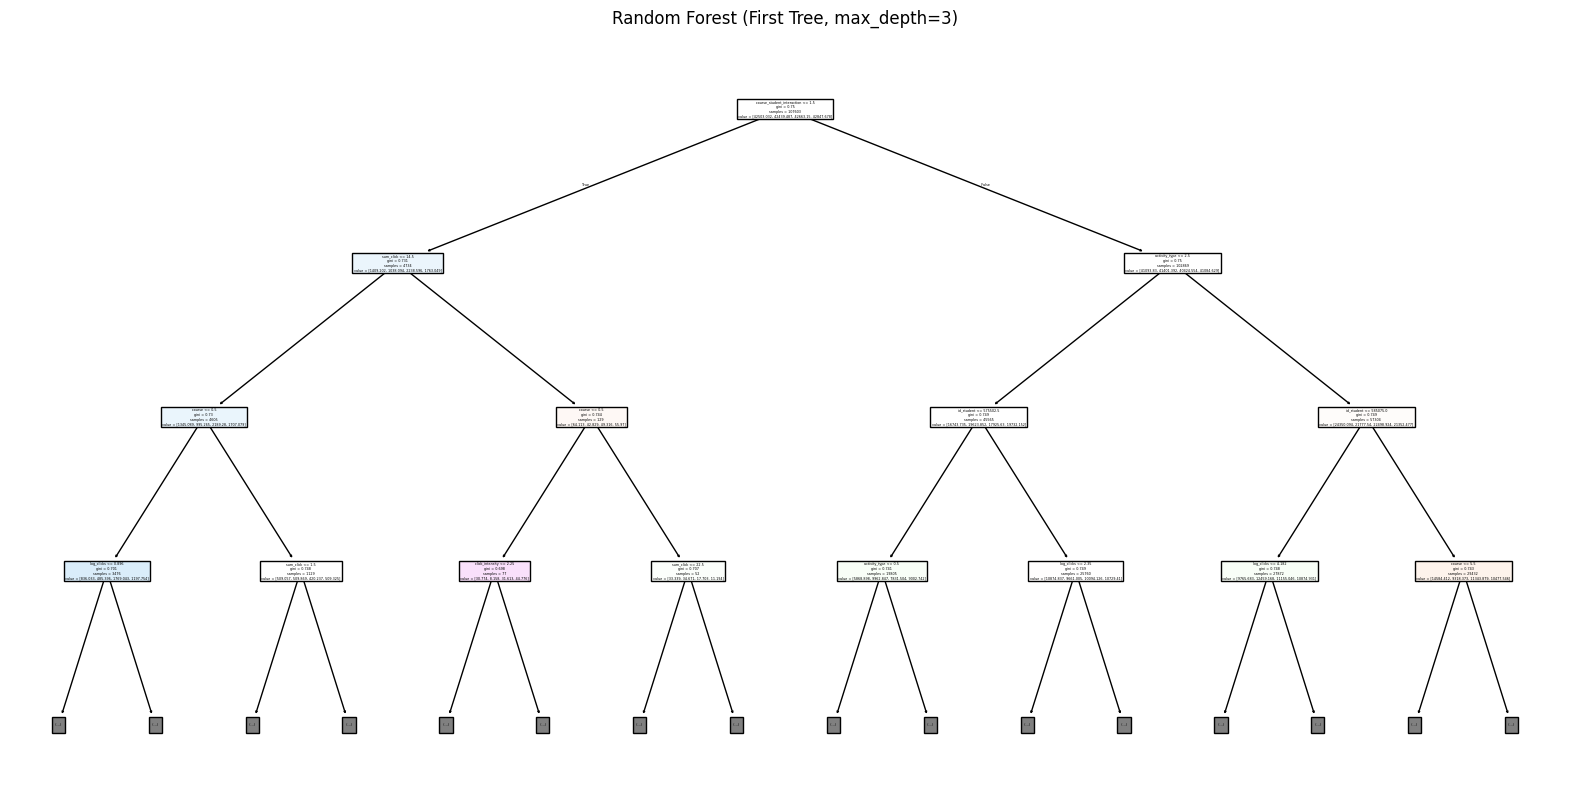

In [9]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from torchviz import make_dot

# ---------- 1. Random Forest ----------
plt.figure(figsize=(20,10))
plot_tree(rf_model.estimators_[0], feature_names=X_train.columns, filled=True, max_depth=3)
plt.title("Random Forest (First Tree, max_depth=3)")
plt.show()


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.693481 to fit


<Figure size 2000x1000 with 0 Axes>

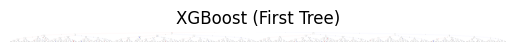

In [19]:

# ---------- 2. XGBoost ----------
try:
    from xgboost import plot_tree as xgb_plot_tree
    plt.figure(figsize=(20,10))
    xgb_plot_tree(y_pred_xgb.model, num_trees=0)  # num_trees=0 -> اولین درخت
    plt.title("XGBoost (First Tree)")
    plt.show()
except:
    print("XGBoost plotting not available")



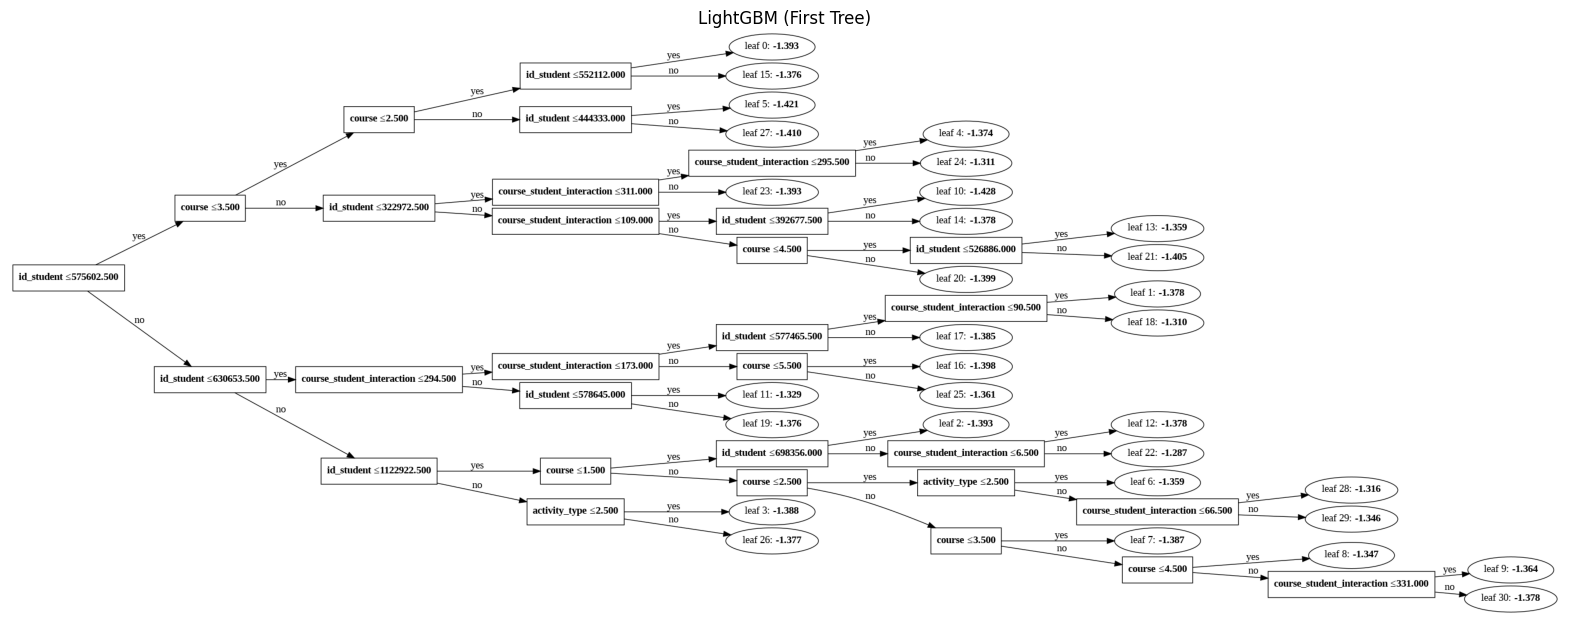

In [18]:
# ---------- 3. LightGBM ----------
try:
    import lightgbm as lgb
    lgb.plot_tree(y_pred_lgb.model, tree_index=0, figsize=(20,10))
    plt.title("LightGBM (First Tree)")
    plt.show()
except:
    print("LightGBM plotting not available")



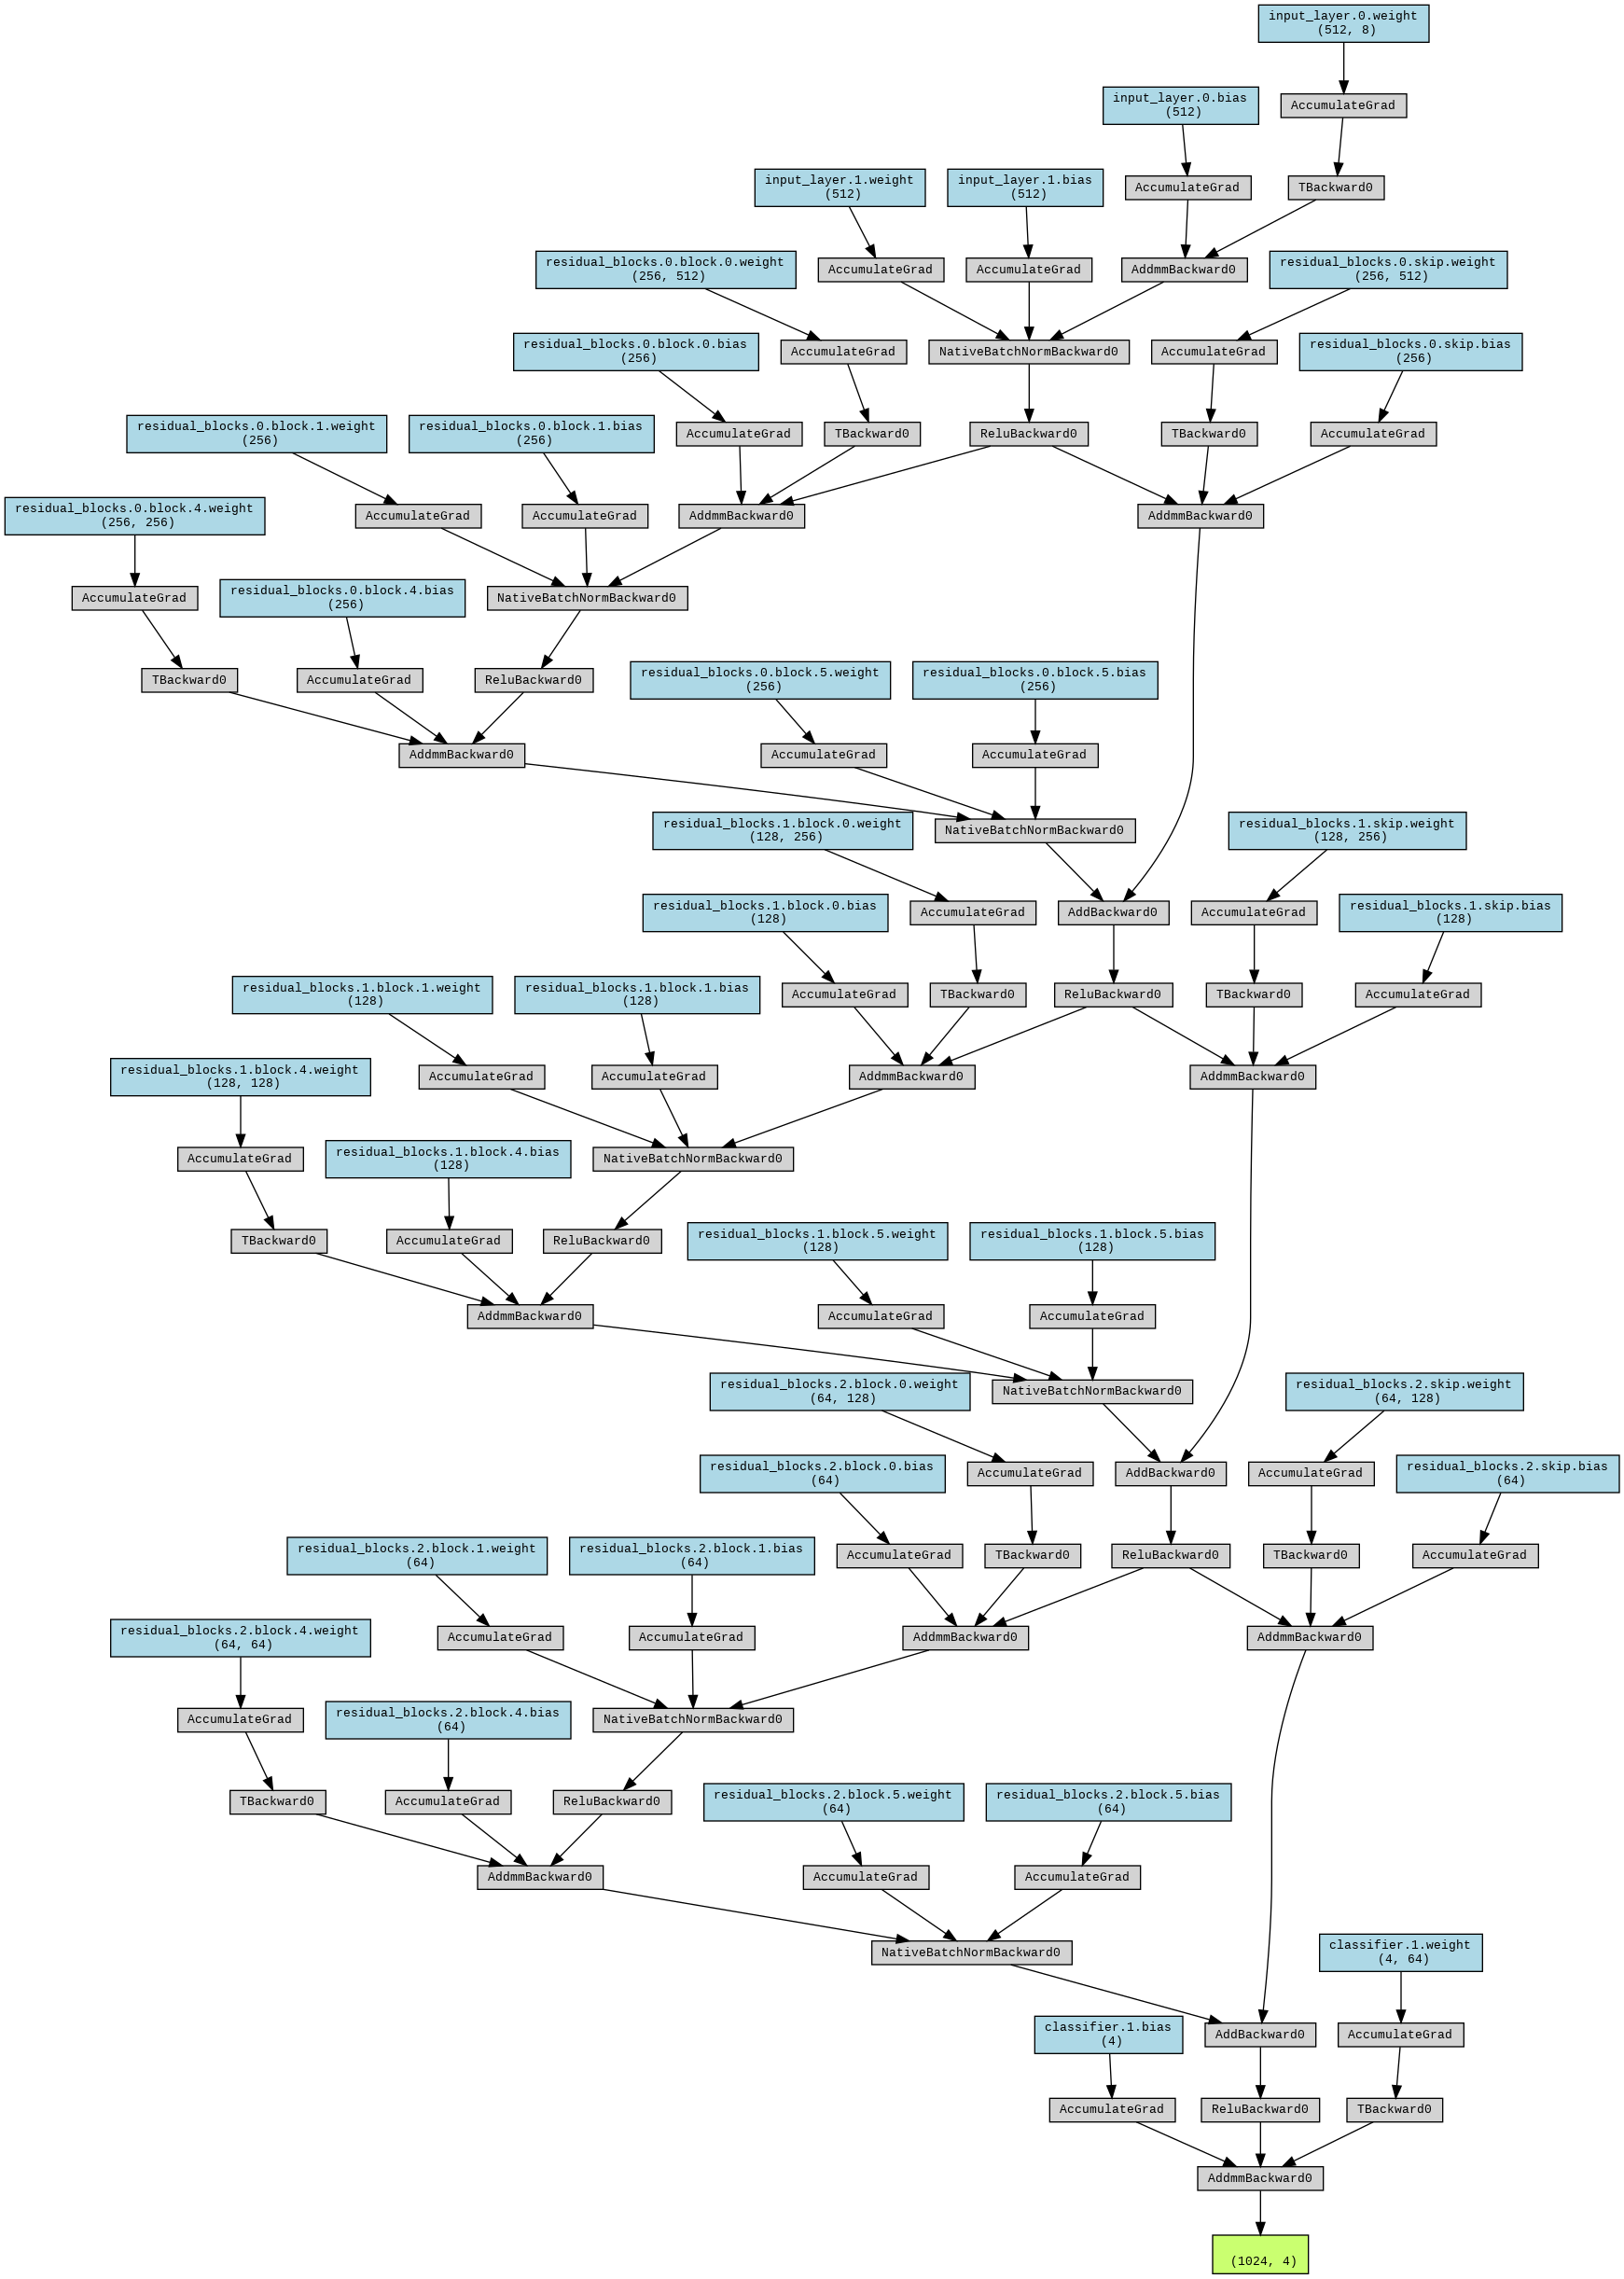

In [12]:
# ---------- 4. TabularResNet ----------
# یک batch نمونه برای ایجاد گراف
sample_X, _ = next(iter(train_loader))
sample_X = sample_X.to(device)
resnet.eval()
y_hat = resnet(sample_X)
# نمایش گراف شبکه
make_dot(y_hat, params=dict(resnet.named_parameters())).render("TabularResNet", format="png")
from IPython.display import Image
Image("TabularResNet.png")
